# Introduction:
A very informative introduction, yep!

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
from pathlib import Path
import xgboost as xgb
import lightgbm as lgbm
import catboost
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
from IPython.display import display
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
import optuna
from sklearn.preprocessing import StandardScaler
from category_encoders import LeaveOneOutEncoder, TargetEncoder, woe

In [6]:
from warnings import filterwarnings
filterwarnings("ignore")

# Loading Data

In [7]:
# setting a base path variable for easy access
BASE_PATH = Path("/kaggle/input/playground-series-s3e6")
train = pd.read_csv(BASE_PATH / "train.csv").drop(columns=["id"])

test = pd.read_csv(BASE_PATH / "test.csv")
# we need the test id column to make the submission
test_idx = test.id
test = test.drop(columns=["id"])

In [8]:
all_datasets = {"train": train, "test": test}

# Setting Upper and Lower Bounds
As taken from https://www.kaggle.com/code/khawajaabaidullah/ps3e6-setting-upper-bounds-may-help

In [9]:
for dataset in all_datasets.values():
    dataset["attic"] = dataset.attic.clip(upper=10000, lower=10)
    dataset["floors"] = dataset.floors.clip(upper=100)
    dataset["squareMeters"] = dataset.squareMeters.clip(upper=99999)
    dataset["basement"] = dataset.basement.clip(upper=10000, lower=10)
    dataset["garage"] = dataset.garage.clip(upper=1000, lower=100)
    dataset["made"] = dataset.made.clip(upper=2021)
    dataset["cityCode"] = dataset.cityCode.clip(upper=99999)

# Checking for categorical values

In [10]:
# pd.concat([train.dtypes.rename("Data Type")] + \
#           [dataset.nunique().rename(f"{dataset_name} UniqueValues") for dataset_name, dataset in all_datasets.items()],
#           axis=1).sort_values(by="train UniqueValues")

In [11]:
feats_to_encode = [col for col in train.columns if train[col].nunique() <= 100]
feats_to_encode

['numberOfRooms',
 'hasYard',
 'hasPool',
 'floors',
 'cityPartRange',
 'numPrevOwners',
 'made',
 'isNewBuilt',
 'hasStormProtector',
 'hasStorageRoom',
 'hasGuestRoom']

# Removing Outliers

## From "made" feature

In [12]:
for dataset in all_datasets.values():
    outlier_newly_built_idx = dataset[(dataset.made==10000) & (dataset.isNewBuilt==1)].index
    dataset.loc[outlier_newly_built_idx, "made"] = 2021

    outlier_old_built_idx = train[(train.made==10000) & (dataset.isNewBuilt==0)].index
    dataset.loc[outlier_old_built_idx, "made"] = int(dataset.made.median())

## From "garage", "attic" and "basement"

In [13]:
#  Calculating average values from train to be used later on
non_outliers = train["garage"] < train.squareMeters
AVG_GARAGE_TO_HOUSE_SIZE_RATIO = np.mean(train[non_outliers]["garage"] / train[non_outliers].squareMeters)

non_outliers = train["attic"] < train.squareMeters
AVG_ATTIC_TO_HOUSE_SIZE_RATIO = np.mean(train[non_outliers]["attic"] / train[non_outliers].squareMeters)

non_outliers = train["basement"] < train.squareMeters
AVG_BASEMENT_TO_HOUSE_SIZE_RATIO = np.mean(train[non_outliers]["basement"] / train[non_outliers].squareMeters)

In [14]:
AVG_GARAGE_TO_HOUSE_SIZE_RATIO, AVG_ATTIC_TO_HOUSE_SIZE_RATIO, AVG_BASEMENT_TO_HOUSE_SIZE_RATIO

(0.03613818458494918, 0.16056940733065303, 0.1725883675760223)

In [15]:
# calculating mean using all values
print("Mean ratio of all values (including outliers): ", np.mean(train.attic / train.squareMeters))

# calculating mean using only valid i.e. non-outlier values
non_outliers = train.attic < train.squareMeters
print("Mean ratio of all values (without outliers): ", np.mean(train[non_outliers].attic / train[non_outliers].squareMeters))

Mean ratio of all values (including outliers):  0.5574612246938441
Mean ratio of all values (without outliers):  0.16056940733065303


## Removing outliers from garage

### train

In [16]:
feature = "garage" 
dataset = train

print(f"\t\t\tRemoving outliers from {feature}...")
outliers = dataset[feature] > dataset.squareMeters
outlier_indices = dataset[outliers].index
print("BEFORE: ")
print(f"\tNumber of rows with {feature} size greater than house size: " , len(dataset[outliers]))
print(f"\tAvg {feature} size of outliers: ", np.mean(dataset[outliers][feature]))

dataset.loc[outlier_indices, f"{feature}"] = (dataset.loc[outlier_indices].squareMeters * \
                                              AVG_GARAGE_TO_HOUSE_SIZE_RATIO).astype("int64").to_numpy()
print("AFTER: ")
print(f"\tNumber of rows with {feature.upper()} size greater than house size: " , len(dataset[dataset[feature] > dataset.squareMeters]))
print(f"\tAvg {feature.upper()} size of outliers: ", np.mean(dataset[outliers][feature]))

			Removing outliers from garage...
BEFORE: 
	Number of rows with garage size greater than house size:  261
	Avg garage size of outliers:  753.0459770114943
AFTER: 
	Number of rows with GARAGE size greater than house size:  0
	Avg GARAGE size of outliers:  15.793103448275861


### test

In [17]:
feature = "garage" 
dataset = test

print(f"\t\t\tRemoving outliers from {feature}...")
outliers = dataset[feature] > dataset.squareMeters
outlier_indices = dataset[outliers].index
print("BEFORE: ")
print(f"\tNumber of rows with {feature} size greater than house size: " , len(dataset[outliers]))
print(f"\tAvg {feature} size of outliers: ", np.mean(dataset[outliers][feature]))

dataset.loc[outlier_indices, f"{feature}"] = (dataset.loc[outlier_indices].squareMeters * \
                                              AVG_GARAGE_TO_HOUSE_SIZE_RATIO).astype("int64").to_numpy()
print("AFTER: ")
print(f"\tNumber of rows with {feature.upper()} size greater than house size: " , len(dataset[dataset[feature] > dataset.squareMeters]))
print(f"\tAvg {feature.upper()} size of outliers: ", np.mean(dataset[outliers][feature]))

			Removing outliers from garage...
BEFORE: 
	Number of rows with garage size greater than house size:  186
	Avg garage size of outliers:  746.6451612903226
AFTER: 
	Number of rows with GARAGE size greater than house size:  0
	Avg GARAGE size of outliers:  16.28494623655914


## Removing from attic

In [18]:
feature = "attic" 
dataset = train

print(f"\t\t\tRemoving outliers from {feature}...")
outliers = dataset[feature] > dataset.squareMeters
outlier_indices = dataset[outliers].index
print("BEFORE: ")
print(f"\tNumber of rows with {feature} size greater than house size: " , len(dataset[outliers]))
print(f"\tAvg {feature} size of outliers: ", np.mean(dataset[outliers][feature]))

dataset.loc[outlier_indices, f"{feature}"] = (dataset.loc[outlier_indices].squareMeters * \
                                              AVG_ATTIC_TO_HOUSE_SIZE_RATIO).astype("int64").to_numpy()
print("AFTER: ")
print(f"\tNumber of rows with {feature.upper()} size greater than house size: " , len(dataset[dataset[feature] > dataset.squareMeters]))
print(f"\tAvg {feature.upper()} size of outliers: ", np.mean(dataset[outliers][feature]))

			Removing outliers from attic...
BEFORE: 
	Number of rows with attic size greater than house size:  1675
	Avg attic size of outliers:  6723.622089552239
AFTER: 
	Number of rows with ATTIC size greater than house size:  0
	Avg ATTIC size of outliers:  521.8692537313433


In [19]:
feature = "attic" 
dataset = test

print(f"\t\t\tRemoving outliers from {feature}...")
outliers = dataset[feature] > dataset.squareMeters
outlier_indices = dataset[outliers].index
print("BEFORE: ")
print(f"\tNumber of rows with {feature} size greater than house size: " , len(dataset[outliers]))
print(f"\tAvg {feature} size of outliers: ", np.mean(dataset[outliers][feature]))

dataset.loc[outlier_indices, f"{feature}"] = (dataset.loc[outlier_indices].squareMeters * \
                                              AVG_ATTIC_TO_HOUSE_SIZE_RATIO).astype("int64").to_numpy()
print("AFTER: ")
print(f"\tNumber of rows with {feature.upper()} size greater than house size: " , len(dataset[dataset[feature] > dataset.squareMeters]))
print(f"\tAvg {feature.upper()} size of outliers: ", np.mean(dataset[outliers][feature]))

			Removing outliers from attic...
BEFORE: 
	Number of rows with attic size greater than house size:  1161
	Avg attic size of outliers:  6684.083548664944
AFTER: 
	Number of rows with ATTIC size greater than house size:  0
	Avg ATTIC size of outliers:  541.9879414298019


## removing from basement

In [20]:
feature = "basement" 
dataset = train

print(f"\t\t\tRemoving outliers from {feature}...")
outliers = dataset[feature] > dataset.squareMeters
outlier_indices = dataset[outliers].index
print("BEFORE: ")
print(f"\tNumber of rows with {feature} size greater than house size: " , len(dataset[outliers]))
print(f"\tAvg {feature} size of outliers: ", np.mean(dataset[outliers][feature]))

dataset.loc[outlier_indices, f"{feature}"] = (dataset.loc[outlier_indices].squareMeters * \
                                              AVG_BASEMENT_TO_HOUSE_SIZE_RATIO).astype("int64").to_numpy()
print("AFTER: ")
print(f"\tNumber of rows with {feature.upper()} size greater than house size: " , len(dataset[dataset[feature] > dataset.squareMeters]))
print(f"\tAvg {feature.upper()} size of outliers: ", np.mean(dataset[outliers][feature]))

			Removing outliers from basement...
BEFORE: 
	Number of rows with basement size greater than house size:  1660
	Avg basement size of outliers:  6549.134939759037
AFTER: 
	Number of rows with BASEMENT size greater than house size:  0
	Avg BASEMENT size of outliers:  535.2626506024096


In [21]:
feature = "basement" 
dataset = test

print(f"\t\t\tRemoving outliers from {feature}...")
outliers = dataset[feature] > dataset.squareMeters
outlier_indices = dataset[outliers].index
print("BEFORE: ")
print(f"\tNumber of rows with {feature} size greater than house size: " , len(dataset[outliers]))
print(f"\tAvg {feature} size of outliers: ", np.mean(dataset[outliers][feature]))

dataset.loc[outlier_indices, f"{feature}"] = (dataset.loc[outlier_indices].squareMeters * \
                                              AVG_BASEMENT_TO_HOUSE_SIZE_RATIO).astype("int64").to_numpy()
print("AFTER: ")
print(f"\tNumber of rows with {feature.upper()} size greater than house size: " , len(dataset[dataset[feature] > dataset.squareMeters]))
print(f"\tAvg {feature.upper()} size of outliers: ", np.mean(dataset[outliers][feature]))

			Removing outliers from basement...
BEFORE: 
	Number of rows with basement size greater than house size:  1130
	Avg basement size of outliers:  6644.1106194690265
AFTER: 
	Number of rows with BASEMENT size greater than house size:  0
	Avg BASEMENT size of outliers:  534.6690265486726


## removing from hasGuestRooms

In [23]:
feature = "hasGuestRoom" 
dataset = train
non_outliers = train.hasGuestRoom < train.numberOfRooms
AVG_GUEST_ROOMS_TO_TOTAL_ROOMS_RATIO = np.mean(train[non_outliers][feature] / train[non_outliers].numberOfRooms)
# print(AVG_GUEST_ROOMS_TO_TOTAL_ROOMS_RATIO)

print(f"\t\t\tRemoving outliers from {feature}...")
outliers = dataset[feature] > dataset.numberOfRooms
outlier_indices = dataset[outliers].index
print("BEFORE: ")
print(f"\tNumber of rows with num of guest rooms greater than total rooms: " , len(dataset[outliers]))
print(f"\tAvg number of guest rooms for outliers: ", np.mean(dataset[outliers][feature]))

dataset.loc[outlier_indices, f"{feature}"] = (dataset.loc[outlier_indices].numberOfRooms * \
                                              AVG_GUEST_ROOMS_TO_TOTAL_ROOMS_RATIO).astype("int64").to_numpy()
print("AFTER: ")
print(f"\tNumber of rows with num of guest rooms greater than total rooms: " , len(dataset[dataset[feature] > dataset.numberOfRooms]))
print(f"\tAvg number of guest rooms for outliers: ", np.mean(dataset[outliers][feature]))

			Removing outliers from hasGuestRoom...
BEFORE: 
	Number of rows with num of guest rooms greater than total rooms:  974
	Avg number of guest rooms for outliers:  7.683778234086242
AFTER: 
	Number of rows with num of guest rooms greater than total rooms:  0
	Avg number of guest rooms for outliers:  0.17248459958932238


In [24]:
feature = "hasGuestRoom" 
dataset = test
non_outliers = train.hasGuestRoom < train.numberOfRooms
AVG_GUEST_ROOMS_TO_TOTAL_ROOMS_RATIO = np.mean(train[non_outliers][feature] / train[non_outliers].numberOfRooms)
# print(AVG_GUEST_ROOMS_TO_TOTAL_ROOMS_RATIO)

print(f"\t\t\tRemoving outliers from {feature}...")
outliers = dataset[feature] > dataset.numberOfRooms
outlier_indices = dataset[outliers].index
print("BEFORE: ")
print(f"\tNumber of rows with num of guest rooms greater than total rooms: " , len(dataset[outliers]))
print(f"\tAvg number of guest rooms for outliers: ", np.mean(dataset[outliers][feature]))

dataset.loc[outlier_indices, f"{feature}"] = (dataset.loc[outlier_indices].numberOfRooms * \
                                              AVG_GUEST_ROOMS_TO_TOTAL_ROOMS_RATIO).astype("int64").to_numpy()
print("AFTER: ")
print(f"\tNumber of rows with num of guest rooms greater than total rooms: " , len(dataset[dataset[feature] > dataset.numberOfRooms]))
print(f"\tAvg number of guest rooms for outliers: ", np.mean(dataset[outliers][feature]))

			Removing outliers from hasGuestRoom...
BEFORE: 
	Number of rows with num of guest rooms greater than total rooms:  634
	Avg number of guest rooms for outliers:  7.55993690851735
AFTER: 
	Number of rows with num of guest rooms greater than total rooms:  0
	Avg number of guest rooms for outliers:  0.16246056782334384


# Preprocess

In [25]:
# [:-1] to remove price i.e. target
numerical_features = [col for col in train.columns if train[col].nunique() > 100][:-1]
del numerical_features[numerical_features.index("cityCode")]

In [26]:
def preprocess(datasets:dict, target:str):
    """Preprocess the data
        datasets: Expects a dict with datasets name as keys and datasets as values
            Valid names for dataets are: [train, test]
        
        target: name of the target column
    """
    loe = LeaveOneOutEncoder(sigma=0.05)
    sc = StandardScaler()
    for dataset_name, dataset in datasets.items():
        dataset_copy = dataset.copy()
        if dataset_name == "train":
            y = dataset_copy[target]
            X = dataset_copy.drop(columns=[target])
            
            numerical_features = [col for col in X.columns if X[col].nunique() > 100]

            feats_to_encode = [col for col in X.columns if X[col].nunique() <= 100]
#             print("FEATS TO ENCOED: ", feats_to_encode)

#             X[numerical_features] = sc.fit_transform(X[numerical_features])
            X[feats_to_encode] = X[feats_to_encode].astype("category")
            X[feats_to_encode] = loe.fit_transform(X[feats_to_encode], y)
            
        elif dataset_name == "test":
            X_test = dataset_copy
#             X_test[numerical_features] = sc.transform(X_test[numerical_features])
            X_test[feats_to_encode] = X_test[feats_to_encode].astype("category")
            X_test[feats_to_encode] = loe.transform(X_test[feats_to_encode])

    return {"train": {"data": X, "target": y}, "test": {"data": X_test}}    

# Cross Validate

In [27]:
def cross_validate(X, y, model, model_verbose):
    N_FOLDS = 5
    cv_scores = np.zeros(N_FOLDS)
    feature_importances_all_folds = np.zeros(shape=(N_FOLDS, len(X.columns)))
    feature_names = X.columns
    
    kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=1337)
    
    for fold_num, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        if model=="XGBoost":
            model = xgb.XGBRegressor(eval_metric="rmse")
        elif model=="LightGBM":
            model = lgbm.LGBMRegressor()
        elif model=="CatBoost":
            model = catboost.CatBoostRegressor(eval_metric="RMSE")
        
        model.fit(X_train, y_train,
                  eval_set=[(X_val, y_val)],
                  early_stopping_rounds=50,
                 verbose=model_verbose)
        
        y_preds = model.predict(X_val)
        
        # to calculate rmse instead of mse, we set squared=False
        rmse = mean_squared_error(y_val, y_preds, squared=False)
        cv_scores[fold_num] = rmse        
        print(f"Fold {fold_num} \t RMSE: {rmse}")
        
        # we'll average feature importances across all folds and plot the averaged values
        feature_importances_all_folds[fold_num] = model.feature_importances_
        
    avg_rmse = np.mean(cv_scores)
    print(f"AVG RMSE: {avg_rmse}")
    
    avg_feature_importances = np.mean(feature_importances_all_folds, axis=0)
    plot_feature_importances(feature_names, avg_feature_importances)

# Plot Feature Importances

In [28]:
def plot_feature_importances(feature_names, feature_importances):
    fig = plt.figure(figsize = (15, 0.35*len(feature_importances)))
    feature_imp_df = pd.DataFrame(data=zip(feature_names, feature_importances), columns=["feature", "importance"]).sort_values(by="importance", ascending=False)
    plt.title('Feature importances', size=25, y=1.05)
    sns.barplot(data=feature_imp_df, x='importance', y='feature')
    plt.show()

# Utility Functions

In [29]:
def try_new_feature(X, y):    
    models = ["XGBoost", "LightGBM", "CatBoost"]
    
    for model in models:
        print(f"{'-'*20} {model} {'-'*20}")
        
        verbose = False
        if model=="LightGBM":
            verbose = -1
            
        cross_validate(X, y, model=model, model_verbose=verbose)

In [30]:
def test_it(datasets:dict):
    processed_datasets = preprocess(datasets, "price")
    X, y = processed_datasets["train"].values()
    try_new_feature(X, y)

# Setting a baseline

FEATS TO ENCOED:  ['numberOfRooms', 'hasYard', 'hasPool', 'floors', 'cityPartRange', 'numPrevOwners', 'made', 'isNewBuilt', 'hasStormProtector', 'hasStorageRoom', 'hasGuestRoom']
-------------------- XGBoost --------------------
Fold 0 	 RMSE: 173413.2079765704
Fold 1 	 RMSE: 139666.06700456078
Fold 2 	 RMSE: 119139.85252150353
Fold 3 	 RMSE: 217559.31942893058
Fold 4 	 RMSE: 208976.50519654868
AVG RMSE: 171750.9904256228


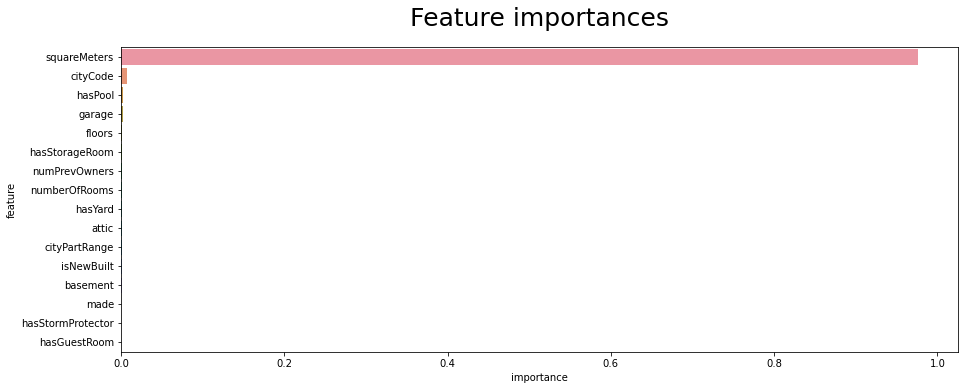

-------------------- LightGBM --------------------
Fold 0 	 RMSE: 170432.00021560793
Fold 1 	 RMSE: 139617.1492344878
Fold 2 	 RMSE: 136761.88609593222
Fold 3 	 RMSE: 272356.3818690652
Fold 4 	 RMSE: 159991.31850861257
AVG RMSE: 175831.74718474114


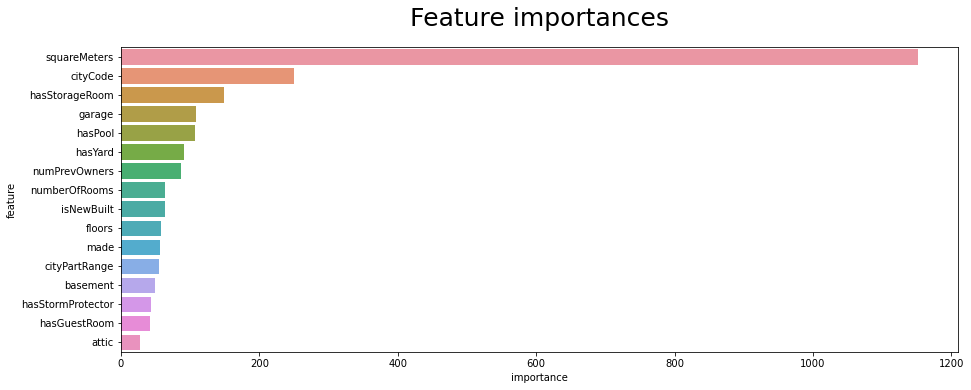

-------------------- CatBoost --------------------
Fold 0 	 RMSE: 171309.9625211329
Fold 1 	 RMSE: 134052.08501639194
Fold 2 	 RMSE: 125326.4084759471
Fold 3 	 RMSE: 250249.2736003004
Fold 4 	 RMSE: 145151.9533909491
AVG RMSE: 165217.9366009443


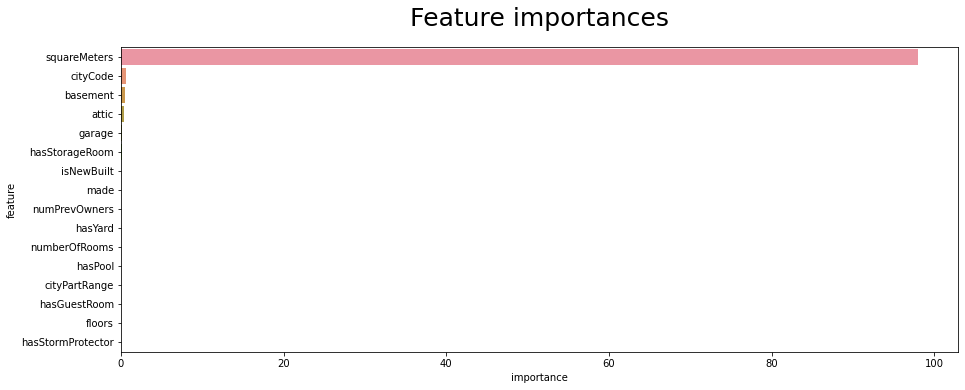

In [31]:
# test_it(all_datasets)

# Preprocessing

In [32]:
processed_datasets = preprocess(all_datasets, target="price")
X = processed_datasets["train"]["data"]
y = processed_datasets["train"]["target"]

FEATS TO ENCOED:  ['numberOfRooms', 'hasYard', 'hasPool', 'floors', 'cityPartRange', 'numPrevOwners', 'made', 'isNewBuilt', 'hasStormProtector', 'hasStorageRoom', 'hasGuestRoom']


# Feature Engineering

In [33]:
#  ------------ We need this for our feature number 8 -----------------
train_copy = all_datasets["train"]
train_copy["block_number"] = train_copy.cityCode // 75
# lets find the average house prices for blocks
avg_house_cost_per_block = train_copy.groupby("block_number")["price"].mean().to_dict()
# ---------------------------------------------------------------------------


def engineer_features(all_datasets):
    all_datasets_fe = {}
    for name, _dataset in all_datasets.items():
        dataset = _dataset.copy()
        # FeatIdea #1: guestRooms/numberOfRooms
        dataset["guestRooms_/_numberOfRooms"] = dataset.hasGuestRoom / dataset.numberOfRooms

        # FeatIdea #2: Number of non guest rooms: NumOfRooms - GuestRooms
        dataset["non_guest_rooms"] = dataset.numberOfRooms - dataset.hasGuestRoom

        # FeatIdea #3: Rooms/Floors: Number of rooms per floor
        dataset["rooms_per_floor"] = dataset.numberOfRooms // dataset.floors

        # FeatIdea #4: Attic/squareMeters:  Attic size to total house size ratio
        dataset["attic_/_squareMeters"] = dataset.attic / dataset.squareMeters

        # FeatIdea #5: Basement/squareMeters: Basement size to total house size ratio
        dataset["basement_/_squareMeters"] = dataset.basement / dataset.squareMeters

        # FeatIdea #6. Garage/squareMeters: Garage size to total house size ratio
        dataset["garage_/_squareMeters"] = dataset.garage / dataset.squareMeters

        # FeatIdea #7: Grouping zip codes
        dataset["block_number"] = dataset.cityCode // 75

        # FeatIdea #8: Add avg price per block as a feature.
        dataset["avg_house_price_in_block"] = dataset.block_number.map(avg_house_cost_per_block)
        
        all_datasets_fe[name] = dataset
    
    return all_datasets_fe

In [34]:
all_datasets_fe = engineer_features(all_datasets)

In [35]:
feats_to_drop = ["cityCode", "block_number", "attic", "basement", "garage",
                 "hasPool", "hasYard", "hasStormProtector", "isNewBuilt"]

In [36]:
for _, dataset in all_datasets_fe.items():
    dataset.drop(columns=feats_to_drop, inplace=True)

FEATS TO ENCOED:  ['numberOfRooms', 'floors', 'cityPartRange', 'numPrevOwners', 'made', 'hasStorageRoom', 'hasGuestRoom', 'rooms_per_floor']
-------------------- XGBoost --------------------
Fold 0 	 RMSE: 180324.25006852302
Fold 1 	 RMSE: 159901.80932776092
Fold 2 	 RMSE: 112841.60719922744
Fold 3 	 RMSE: 197783.0538448341
Fold 4 	 RMSE: 224300.39918989965
AVG RMSE: 175030.22392604902


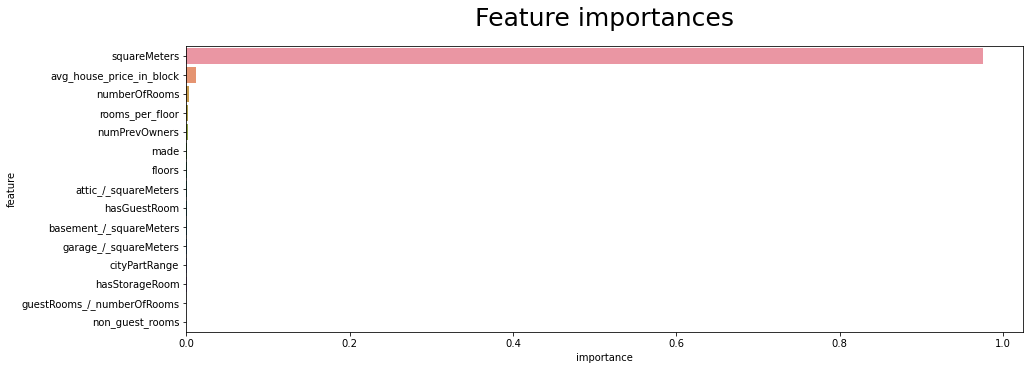

-------------------- LightGBM --------------------
Fold 0 	 RMSE: 179706.17287761896
Fold 1 	 RMSE: 136182.794131431
Fold 2 	 RMSE: 119596.29176434506
Fold 3 	 RMSE: 254626.83899579052
Fold 4 	 RMSE: 153204.53336677302
AVG RMSE: 168663.32622719172


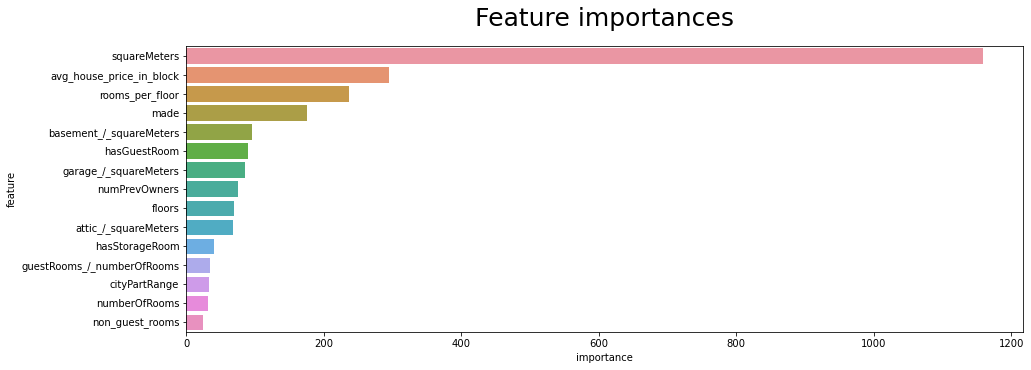

-------------------- CatBoost --------------------
Fold 0 	 RMSE: 178091.070523554
Fold 1 	 RMSE: 134874.7097118993
Fold 2 	 RMSE: 117443.24779988085
Fold 3 	 RMSE: 236035.85402885833
Fold 4 	 RMSE: 142917.6062148727
AVG RMSE: 161872.49765581303


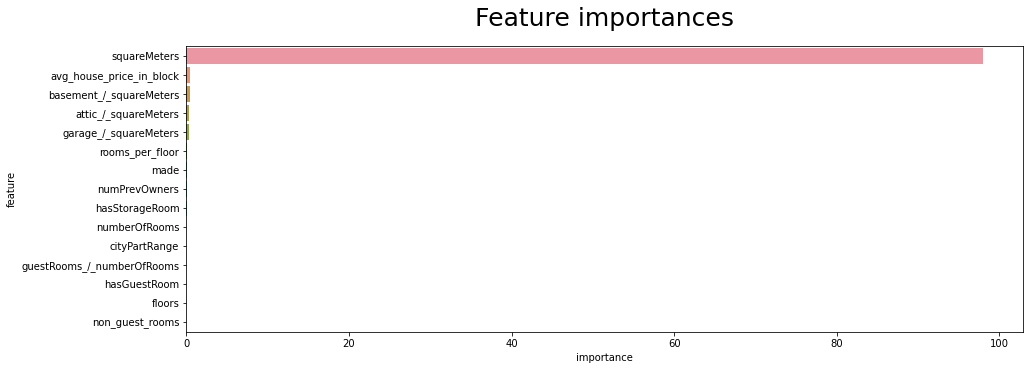

In [37]:
test_it(all_datasets_fe)

# Tuning XGBoost

In [38]:
processed_datasets = preprocess(all_datasets_fe, target="price")
X = processed_datasets["train"]["data"]
y = processed_datasets["train"]["target"]

def objective_xgb(trial, X, y):
    params = {
        'tree_method': "gpu_hist",
        'n_estimators': trial.suggest_int('n_estimators', 50, 400),
        'max_depth': trial.suggest_int('max_depth', 2, 20),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 15),
        'gamma': trial.suggest_loguniform('gamma', 0.00001, 0.3),
        'subsample': trial.suggest_float('subsample', 0.2, 1.0, step=0.05),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0, step=0.05),
        'early_stopping_rounds': trial.suggest_int("early_stoppig_rounds", 40, 100)
    }
    # we're gonna train on the combined dataset but, we'll only calculate the validation score only on comp data

    N_FOLDS = 5
    all_scores = np.zeros(N_FOLDS)

    skf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=1337)

    for fold_id, (train_idx, val_idx) in enumerate(skf.split(X)):
        
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        model = xgb.XGBRegressor(**params)
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
        
        y_pred = model.predict(X_val)
                
        rmse = mean_squared_error(y_val, y_pred, squared=False)        
        all_scores[fold_id] = rmse
    
    avg_rmse = np.mean(all_scores)
    
    print(f"Avg RMSE: {avg_rmse}")
    
    return avg_rmse

study_xgb = optuna.create_study(study_name="xgboost_tuning", direction="minimize")
func = lambda trial: objective_xgb(trial, X, y)
study_xgb.optimize(func, n_trials=100)

[I 2023-02-20 18:19:32,818] A new study created in memory with name: xgboost_tuning


FEATS TO ENCOED:  ['numberOfRooms', 'floors', 'cityPartRange', 'numPrevOwners', 'made', 'hasStorageRoom', 'hasGuestRoom', 'rooms_per_floor']


[I 2023-02-20 18:19:39,546] Trial 0 finished with value: 241719.69064804987 and parameters: {'n_estimators': 103, 'max_depth': 12, 'learning_rate': 0.04411806255444231, 'min_child_weight': 14, 'gamma': 0.001905994857569221, 'subsample': 0.2, 'colsample_bytree': 0.7, 'early_stoppig_rounds': 41}. Best is trial 0 with value: 241719.69064804987.


Avg RMSE: 241719.69064804987


[I 2023-02-20 18:19:41,099] Trial 1 finished with value: 185527.89695264315 and parameters: {'n_estimators': 168, 'max_depth': 4, 'learning_rate': 0.10982647975035917, 'min_child_weight': 9, 'gamma': 0.21430786604769, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.9000000000000001, 'early_stoppig_rounds': 82}. Best is trial 1 with value: 185527.89695264315.


Avg RMSE: 185527.89695264315


[I 2023-02-20 18:19:47,466] Trial 2 finished with value: 202321.14479533883 and parameters: {'n_estimators': 162, 'max_depth': 11, 'learning_rate': 0.11083350353987899, 'min_child_weight': 15, 'gamma': 0.003999969182003028, 'subsample': 0.25, 'colsample_bytree': 0.8, 'early_stoppig_rounds': 66}. Best is trial 1 with value: 185527.89695264315.


Avg RMSE: 202321.14479533883


[I 2023-02-20 18:19:56,786] Trial 3 finished with value: 294114.89512537874 and parameters: {'n_estimators': 316, 'max_depth': 7, 'learning_rate': 0.010494604055807833, 'min_child_weight': 10, 'gamma': 0.00031681961347381946, 'subsample': 0.8, 'colsample_bytree': 0.8, 'early_stoppig_rounds': 49}. Best is trial 1 with value: 185527.89695264315.


Avg RMSE: 294114.89512537874


[I 2023-02-20 18:19:59,546] Trial 4 finished with value: 192832.44454090117 and parameters: {'n_estimators': 299, 'max_depth': 4, 'learning_rate': 0.04760341852439843, 'min_child_weight': 8, 'gamma': 0.005073491079200213, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.8, 'early_stoppig_rounds': 52}. Best is trial 1 with value: 185527.89695264315.


Avg RMSE: 192832.44454090117


[I 2023-02-20 18:21:56,128] Trial 5 finished with value: 238227.03487896273 and parameters: {'n_estimators': 286, 'max_depth': 17, 'learning_rate': 0.04597307046788091, 'min_child_weight': 5, 'gamma': 3.308324762184258e-05, 'subsample': 0.7, 'colsample_bytree': 0.6000000000000001, 'early_stoppig_rounds': 99}. Best is trial 1 with value: 185527.89695264315.


Avg RMSE: 238227.03487896273


[I 2023-02-20 18:21:57,291] Trial 6 finished with value: 207870.0004675652 and parameters: {'n_estimators': 158, 'max_depth': 3, 'learning_rate': 0.046114356894927495, 'min_child_weight': 5, 'gamma': 2.049800629420649e-05, 'subsample': 0.8500000000000001, 'colsample_bytree': 0.8, 'early_stoppig_rounds': 79}. Best is trial 1 with value: 185527.89695264315.


Avg RMSE: 207870.0004675652


[I 2023-02-20 18:21:59,888] Trial 7 finished with value: 206646.34950015193 and parameters: {'n_estimators': 291, 'max_depth': 3, 'learning_rate': 0.033798366109685965, 'min_child_weight': 9, 'gamma': 0.000500425136851733, 'subsample': 0.2, 'colsample_bytree': 0.9000000000000001, 'early_stoppig_rounds': 83}. Best is trial 1 with value: 185527.89695264315.


Avg RMSE: 206646.34950015193


[I 2023-02-20 18:22:20,719] Trial 8 finished with value: 208775.63216355472 and parameters: {'n_estimators': 138, 'max_depth': 12, 'learning_rate': 0.03373207821600067, 'min_child_weight': 9, 'gamma': 0.00442379890146337, 'subsample': 0.95, 'colsample_bytree': 0.8, 'early_stoppig_rounds': 93}. Best is trial 1 with value: 185527.89695264315.


Avg RMSE: 208775.63216355472


[I 2023-02-20 18:25:42,416] Trial 9 finished with value: 247549.49106348358 and parameters: {'n_estimators': 372, 'max_depth': 19, 'learning_rate': 0.11092905080919525, 'min_child_weight': 2, 'gamma': 0.0005545731737501777, 'subsample': 0.75, 'colsample_bytree': 0.75, 'early_stoppig_rounds': 94}. Best is trial 1 with value: 185527.89695264315.


Avg RMSE: 247549.49106348358


[I 2023-02-20 18:25:44,035] Trial 10 finished with value: 419921.5436546967 and parameters: {'n_estimators': 52, 'max_depth': 7, 'learning_rate': 0.2643235385907544, 'min_child_weight': 12, 'gamma': 0.22470260576131854, 'subsample': 0.45, 'colsample_bytree': 0.30000000000000004, 'early_stoppig_rounds': 66}. Best is trial 1 with value: 185527.89695264315.


Avg RMSE: 419921.5436546967


[I 2023-02-20 18:25:46,364] Trial 11 finished with value: 174525.31532015975 and parameters: {'n_estimators': 219, 'max_depth': 6, 'learning_rate': 0.09886092235409805, 'min_child_weight': 6, 'gamma': 0.18972543025398964, 'subsample': 0.5, 'colsample_bytree': 1.0, 'early_stoppig_rounds': 54}. Best is trial 11 with value: 174525.31532015975.


Avg RMSE: 174525.31532015975


[I 2023-02-20 18:25:49,001] Trial 12 finished with value: 174541.0277467141 and parameters: {'n_estimators': 219, 'max_depth': 7, 'learning_rate': 0.11122808247130263, 'min_child_weight': 5, 'gamma': 0.2983682548037376, 'subsample': 0.45, 'colsample_bytree': 1.0, 'early_stoppig_rounds': 57}. Best is trial 11 with value: 174525.31532015975.


Avg RMSE: 174541.0277467141


[I 2023-02-20 18:25:51,731] Trial 13 finished with value: 180126.82466936245 and parameters: {'n_estimators': 225, 'max_depth': 8, 'learning_rate': 0.1947850526361367, 'min_child_weight': 5, 'gamma': 0.048462082767036174, 'subsample': 0.4, 'colsample_bytree': 1.0, 'early_stoppig_rounds': 57}. Best is trial 11 with value: 174525.31532015975.


Avg RMSE: 180126.82466936245


[I 2023-02-20 18:26:12,171] Trial 14 finished with value: 318452.3523922913 and parameters: {'n_estimators': 223, 'max_depth': 9, 'learning_rate': 0.08266647722841415, 'min_child_weight': 1, 'gamma': 0.038297151514300874, 'subsample': 0.4, 'colsample_bytree': 0.35000000000000003, 'early_stoppig_rounds': 58}. Best is trial 11 with value: 174525.31532015975.


Avg RMSE: 318452.3523922913


[I 2023-02-20 18:26:21,693] Trial 15 finished with value: 169342.3142476628 and parameters: {'n_estimators': 238, 'max_depth': 15, 'learning_rate': 0.19609030857358115, 'min_child_weight': 3, 'gamma': 0.27857708395189434, 'subsample': 0.5, 'colsample_bytree': 1.0, 'early_stoppig_rounds': 40}. Best is trial 15 with value: 169342.3142476628.


Avg RMSE: 169342.3142476628


[I 2023-02-20 18:28:33,209] Trial 16 finished with value: 489536.34418915474 and parameters: {'n_estimators': 250, 'max_depth': 16, 'learning_rate': 0.1892333375951017, 'min_child_weight': 2, 'gamma': 0.047329556050342725, 'subsample': 0.5, 'colsample_bytree': 0.45, 'early_stoppig_rounds': 40}. Best is trial 15 with value: 169342.3142476628.


Avg RMSE: 489536.34418915474


[I 2023-02-20 18:28:47,921] Trial 17 finished with value: 279261.0265666503 and parameters: {'n_estimators': 347, 'max_depth': 14, 'learning_rate': 0.18603296333010041, 'min_child_weight': 7, 'gamma': 0.02925609265049456, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.6000000000000001, 'early_stoppig_rounds': 47}. Best is trial 15 with value: 169342.3142476628.


Avg RMSE: 279261.0265666503


[I 2023-02-20 18:29:15,347] Trial 18 finished with value: 179561.11993272297 and parameters: {'n_estimators': 399, 'max_depth': 20, 'learning_rate': 0.25856820861001417, 'min_child_weight': 3, 'gamma': 0.09388058562106376, 'subsample': 0.55, 'colsample_bytree': 0.95, 'early_stoppig_rounds': 44}. Best is trial 15 with value: 169342.3142476628.


Avg RMSE: 179561.11993272297


[I 2023-02-20 18:30:27,626] Trial 19 finished with value: 343793.4080226786 and parameters: {'n_estimators': 259, 'max_depth': 15, 'learning_rate': 0.077863654584704, 'min_child_weight': 7, 'gamma': 0.017305844117648468, 'subsample': 0.65, 'colsample_bytree': 0.45, 'early_stoppig_rounds': 53}. Best is trial 15 with value: 169342.3142476628.


Avg RMSE: 343793.4080226786


[I 2023-02-20 18:30:34,567] Trial 20 finished with value: 181991.02056447725 and parameters: {'n_estimators': 196, 'max_depth': 10, 'learning_rate': 0.1610081880440335, 'min_child_weight': 3, 'gamma': 0.013423131112107124, 'subsample': 0.35000000000000003, 'colsample_bytree': 0.9000000000000001, 'early_stoppig_rounds': 73}. Best is trial 15 with value: 169342.3142476628.


Avg RMSE: 181991.02056447725


[I 2023-02-20 18:30:36,730] Trial 21 finished with value: 165964.46225702317 and parameters: {'n_estimators': 199, 'max_depth': 6, 'learning_rate': 0.14020054000760862, 'min_child_weight': 4, 'gamma': 0.2811092687887282, 'subsample': 0.5, 'colsample_bytree': 1.0, 'early_stoppig_rounds': 60}. Best is trial 21 with value: 165964.46225702317.


Avg RMSE: 165964.46225702317


[I 2023-02-20 18:30:38,221] Trial 22 finished with value: 170610.46897705324 and parameters: {'n_estimators': 198, 'max_depth': 6, 'learning_rate': 0.2870649938762726, 'min_child_weight': 4, 'gamma': 0.10323529141863615, 'subsample': 0.5, 'colsample_bytree': 1.0, 'early_stoppig_rounds': 61}. Best is trial 21 with value: 165964.46225702317.


Avg RMSE: 170610.46897705324


[I 2023-02-20 18:30:39,402] Trial 23 finished with value: 174046.89077326137 and parameters: {'n_estimators': 188, 'max_depth': 5, 'learning_rate': 0.2945353477074852, 'min_child_weight': 3, 'gamma': 0.09541035375910693, 'subsample': 0.55, 'colsample_bytree': 0.9000000000000001, 'early_stoppig_rounds': 63}. Best is trial 21 with value: 165964.46225702317.


Avg RMSE: 174046.89077326137


[I 2023-02-20 18:30:40,196] Trial 24 finished with value: 425128.9472073798 and parameters: {'n_estimators': 115, 'max_depth': 2, 'learning_rate': 0.1478311256287326, 'min_child_weight': 4, 'gamma': 0.1265101629453997, 'subsample': 0.35000000000000003, 'colsample_bytree': 0.2, 'early_stoppig_rounds': 71}. Best is trial 21 with value: 165964.46225702317.


Avg RMSE: 425128.9472073798


[I 2023-02-20 18:31:49,502] Trial 25 finished with value: 313697.7905464633 and parameters: {'n_estimators': 260, 'max_depth': 13, 'learning_rate': 0.23317243642219038, 'min_child_weight': 2, 'gamma': 0.29987597184441794, 'subsample': 0.65, 'colsample_bytree': 0.7, 'early_stoppig_rounds': 62}. Best is trial 21 with value: 165964.46225702317.


Avg RMSE: 313697.7905464633


[I 2023-02-20 18:32:45,196] Trial 26 finished with value: 193566.15704849985 and parameters: {'n_estimators': 192, 'max_depth': 18, 'learning_rate': 0.284297975313559, 'min_child_weight': 1, 'gamma': 0.08824928697236398, 'subsample': 0.5, 'colsample_bytree': 0.95, 'early_stoppig_rounds': 73}. Best is trial 21 with value: 165964.46225702317.


Avg RMSE: 193566.15704849985


[I 2023-02-20 18:32:49,285] Trial 27 finished with value: 169655.34419291344 and parameters: {'n_estimators': 245, 'max_depth': 9, 'learning_rate': 0.14641217835050774, 'min_child_weight': 4, 'gamma': 0.10038605830705552, 'subsample': 0.55, 'colsample_bytree': 0.95, 'early_stoppig_rounds': 46}. Best is trial 21 with value: 165964.46225702317.


Avg RMSE: 169655.34419291344


[I 2023-02-20 18:32:55,929] Trial 28 finished with value: 189148.4942668599 and parameters: {'n_estimators': 243, 'max_depth': 9, 'learning_rate': 0.13986564297727738, 'min_child_weight': 6, 'gamma': 0.06421463155017879, 'subsample': 0.7, 'colsample_bytree': 0.8500000000000001, 'early_stoppig_rounds': 46}. Best is trial 21 with value: 165964.46225702317.


Avg RMSE: 189148.4942668599


[I 2023-02-20 18:33:01,922] Trial 29 finished with value: 255901.83301937938 and parameters: {'n_estimators': 83, 'max_depth': 11, 'learning_rate': 0.2150952630588517, 'min_child_weight': 12, 'gamma': 0.022131789558714084, 'subsample': 0.4, 'colsample_bytree': 0.7, 'early_stoppig_rounds': 42}. Best is trial 21 with value: 165964.46225702317.


Avg RMSE: 255901.83301937938


[I 2023-02-20 18:33:11,320] Trial 30 finished with value: 169754.15226295358 and parameters: {'n_estimators': 276, 'max_depth': 13, 'learning_rate': 0.15308623741128463, 'min_child_weight': 4, 'gamma': 0.16870851072739107, 'subsample': 0.55, 'colsample_bytree': 0.95, 'early_stoppig_rounds': 40}. Best is trial 21 with value: 165964.46225702317.


Avg RMSE: 169754.15226295358


[I 2023-02-20 18:33:20,288] Trial 31 finished with value: 171886.22223923155 and parameters: {'n_estimators': 277, 'max_depth': 13, 'learning_rate': 0.1586264833239332, 'min_child_weight': 4, 'gamma': 0.14461040004422784, 'subsample': 0.55, 'colsample_bytree': 0.95, 'early_stoppig_rounds': 40}. Best is trial 21 with value: 165964.46225702317.


Avg RMSE: 171886.22223923155


[I 2023-02-20 18:33:42,774] Trial 32 finished with value: 178020.23911645098 and parameters: {'n_estimators': 325, 'max_depth': 14, 'learning_rate': 0.1358404064037404, 'min_child_weight': 3, 'gamma': 0.15604674087274326, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.9000000000000001, 'early_stoppig_rounds': 48}. Best is trial 21 with value: 165964.46225702317.


Avg RMSE: 178020.23911645098


[I 2023-02-20 18:33:48,796] Trial 33 finished with value: 182167.57885145638 and parameters: {'n_estimators': 268, 'max_depth': 11, 'learning_rate': 0.1993905967305504, 'min_child_weight': 6, 'gamma': 0.2990519854744459, 'subsample': 0.65, 'colsample_bytree': 0.95, 'early_stoppig_rounds': 43}. Best is trial 21 with value: 165964.46225702317.


Avg RMSE: 182167.57885145638


[I 2023-02-20 18:34:09,725] Trial 34 finished with value: 212743.11212892304 and parameters: {'n_estimators': 235, 'max_depth': 16, 'learning_rate': 0.22413361775581064, 'min_child_weight': 4, 'gamma': 0.05488368127086349, 'subsample': 0.45, 'colsample_bytree': 0.8500000000000001, 'early_stoppig_rounds': 50}. Best is trial 21 with value: 165964.46225702317.


Avg RMSE: 212743.11212892304


[I 2023-02-20 18:34:21,552] Trial 35 finished with value: 187913.40277603798 and parameters: {'n_estimators': 168, 'max_depth': 9, 'learning_rate': 0.1277704896449462, 'min_child_weight': 1, 'gamma': 0.14195353539508684, 'subsample': 0.55, 'colsample_bytree': 0.8500000000000001, 'early_stoppig_rounds': 44}. Best is trial 21 with value: 165964.46225702317.


Avg RMSE: 187913.40277603798


[I 2023-02-20 18:34:30,266] Trial 36 finished with value: 178610.9338038068 and parameters: {'n_estimators': 316, 'max_depth': 12, 'learning_rate': 0.16935290369648273, 'min_child_weight': 7, 'gamma': 0.010081130418153976, 'subsample': 0.7, 'colsample_bytree': 1.0, 'early_stoppig_rounds': 50}. Best is trial 21 with value: 165964.46225702317.


Avg RMSE: 178610.9338038068


[I 2023-02-20 18:35:09,292] Trial 37 finished with value: 230143.75404740166 and parameters: {'n_estimators': 303, 'max_depth': 10, 'learning_rate': 0.1275169935597491, 'min_child_weight': 2, 'gamma': 0.03429604369423065, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.65, 'early_stoppig_rounds': 46}. Best is trial 21 with value: 165964.46225702317.


Avg RMSE: 230143.75404740166


[I 2023-02-20 18:35:35,697] Trial 38 finished with value: 199138.12292614914 and parameters: {'n_estimators': 338, 'max_depth': 15, 'learning_rate': 0.1651781127588998, 'min_child_weight': 5, 'gamma': 0.17188826835490265, 'subsample': 0.8500000000000001, 'colsample_bytree': 0.8500000000000001, 'early_stoppig_rounds': 40}. Best is trial 21 with value: 165964.46225702317.


Avg RMSE: 199138.12292614914


[I 2023-02-20 18:35:37,321] Trial 39 finished with value: 213126.24425499086 and parameters: {'n_estimators': 171, 'max_depth': 5, 'learning_rate': 0.23374090651220888, 'min_child_weight': 8, 'gamma': 0.06522728790653648, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.75, 'early_stoppig_rounds': 53}. Best is trial 21 with value: 165964.46225702317.


Avg RMSE: 213126.24425499086


[I 2023-02-20 18:36:27,195] Trial 40 finished with value: 279161.1388762655 and parameters: {'n_estimators': 279, 'max_depth': 12, 'learning_rate': 0.06502059187288096, 'min_child_weight': 4, 'gamma': 0.00956019529324042, 'subsample': 0.45, 'colsample_bytree': 0.5, 'early_stoppig_rounds': 77}. Best is trial 21 with value: 165964.46225702317.


Avg RMSE: 279161.1388762655


[I 2023-02-20 18:36:28,843] Trial 41 finished with value: 166902.4053105331 and parameters: {'n_estimators': 204, 'max_depth': 6, 'learning_rate': 0.23821090209779774, 'min_child_weight': 4, 'gamma': 0.0927850089880399, 'subsample': 0.5, 'colsample_bytree': 1.0, 'early_stoppig_rounds': 61}. Best is trial 21 with value: 165964.46225702317.


Avg RMSE: 166902.4053105331


[I 2023-02-20 18:36:32,636] Trial 42 finished with value: 172383.14321623807 and parameters: {'n_estimators': 209, 'max_depth': 8, 'learning_rate': 0.1821068617234945, 'min_child_weight': 3, 'gamma': 0.1931607333995445, 'subsample': 0.55, 'colsample_bytree': 0.95, 'early_stoppig_rounds': 66}. Best is trial 21 with value: 165964.46225702317.


Avg RMSE: 172383.14321623807


[I 2023-02-20 18:36:33,745] Trial 43 finished with value: 173435.7543188822 and parameters: {'n_estimators': 144, 'max_depth': 4, 'learning_rate': 0.2256885988236072, 'min_child_weight': 5, 'gamma': 0.07163590459191636, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.95, 'early_stoppig_rounds': 59}. Best is trial 21 with value: 165964.46225702317.


Avg RMSE: 173435.7543188822


[I 2023-02-20 18:36:35,517] Trial 44 finished with value: 173285.78895791268 and parameters: {'n_estimators': 239, 'max_depth': 5, 'learning_rate': 0.11961177168260057, 'min_child_weight': 6, 'gamma': 0.027400038504516392, 'subsample': 0.5, 'colsample_bytree': 1.0, 'early_stoppig_rounds': 55}. Best is trial 21 with value: 165964.46225702317.


Avg RMSE: 173285.78895791268


[I 2023-02-20 18:36:40,010] Trial 45 finished with value: 175210.51657530025 and parameters: {'n_estimators': 178, 'max_depth': 8, 'learning_rate': 0.14839718390833753, 'min_child_weight': 2, 'gamma': 0.28225168763973935, 'subsample': 0.45, 'colsample_bytree': 0.9000000000000001, 'early_stoppig_rounds': 50}. Best is trial 21 with value: 165964.46225702317.


Avg RMSE: 175210.51657530025


[I 2023-02-20 18:36:42,871] Trial 46 finished with value: 181719.4878457322 and parameters: {'n_estimators': 208, 'max_depth': 6, 'learning_rate': 0.09855947520933515, 'min_child_weight': 15, 'gamma': 0.10995773289544132, 'subsample': 0.75, 'colsample_bytree': 1.0, 'early_stoppig_rounds': 84}. Best is trial 21 with value: 165964.46225702317.


Avg RMSE: 181719.4878457322


[I 2023-02-20 18:37:01,818] Trial 47 finished with value: 220465.3052388228 and parameters: {'n_estimators': 145, 'max_depth': 17, 'learning_rate': 0.25528649212928184, 'min_child_weight': 4, 'gamma': 0.1752423705413244, 'subsample': 0.4, 'colsample_bytree': 0.8, 'early_stoppig_rounds': 44}. Best is trial 21 with value: 165964.46225702317.


Avg RMSE: 220465.3052388228


[I 2023-02-20 18:37:04,703] Trial 48 finished with value: 188226.37657993456 and parameters: {'n_estimators': 299, 'max_depth': 7, 'learning_rate': 0.20146174567853017, 'min_child_weight': 11, 'gamma': 0.04063801660368043, 'subsample': 0.65, 'colsample_bytree': 0.9000000000000001, 'early_stoppig_rounds': 67}. Best is trial 21 with value: 165964.46225702317.


Avg RMSE: 188226.37657993456


[I 2023-02-20 18:37:06,345] Trial 49 finished with value: 207340.5519930392 and parameters: {'n_estimators': 232, 'max_depth': 3, 'learning_rate': 0.17129912683848347, 'min_child_weight': 14, 'gamma': 0.20084292931460213, 'subsample': 0.55, 'colsample_bytree': 0.75, 'early_stoppig_rounds': 56}. Best is trial 21 with value: 165964.46225702317.


Avg RMSE: 207340.5519930392


[I 2023-02-20 18:37:16,770] Trial 50 finished with value: 186185.23663408574 and parameters: {'n_estimators': 252, 'max_depth': 13, 'learning_rate': 0.10080634618456887, 'min_child_weight': 8, 'gamma': 0.07016597270066345, 'subsample': 0.5, 'colsample_bytree': 0.95, 'early_stoppig_rounds': 51}. Best is trial 21 with value: 165964.46225702317.


Avg RMSE: 186185.23663408574


[I 2023-02-20 18:37:18,458] Trial 51 finished with value: 175366.17812640834 and parameters: {'n_estimators': 206, 'max_depth': 6, 'learning_rate': 0.2875472110274458, 'min_child_weight': 5, 'gamma': 0.11401711596211027, 'subsample': 0.5, 'colsample_bytree': 1.0, 'early_stoppig_rounds': 63}. Best is trial 21 with value: 165964.46225702317.


Avg RMSE: 175366.17812640834


[I 2023-02-20 18:37:19,978] Trial 52 finished with value: 168967.6374248293 and parameters: {'n_estimators': 218, 'max_depth': 6, 'learning_rate': 0.24665174303191242, 'min_child_weight': 4, 'gamma': 0.09572874219747045, 'subsample': 0.45, 'colsample_bytree': 1.0, 'early_stoppig_rounds': 61}. Best is trial 21 with value: 165964.46225702317.


Avg RMSE: 168967.6374248293


[I 2023-02-20 18:37:21,023] Trial 53 finished with value: 162597.78050371233 and parameters: {'n_estimators': 221, 'max_depth': 4, 'learning_rate': 0.20322409637027844, 'min_child_weight': 3, 'gamma': 0.04850834705904382, 'subsample': 0.45, 'colsample_bytree': 1.0, 'early_stoppig_rounds': 69}. Best is trial 53 with value: 162597.78050371233.


Avg RMSE: 162597.78050371233


[I 2023-02-20 18:37:22,147] Trial 54 finished with value: 188112.6728030067 and parameters: {'n_estimators': 217, 'max_depth': 2, 'learning_rate': 0.24968892886595953, 'min_child_weight': 3, 'gamma': 0.04775165795959521, 'subsample': 0.35000000000000003, 'colsample_bytree': 1.0, 'early_stoppig_rounds': 69}. Best is trial 53 with value: 162597.78050371233.


Avg RMSE: 188112.6728030067


[I 2023-02-20 18:37:23,531] Trial 55 finished with value: 179375.08108574938 and parameters: {'n_estimators': 155, 'max_depth': 3, 'learning_rate': 0.20909165706667876, 'min_child_weight': 2, 'gamma': 0.08100788226326194, 'subsample': 0.45, 'colsample_bytree': 0.9000000000000001, 'early_stoppig_rounds': 76}. Best is trial 53 with value: 162597.78050371233.


Avg RMSE: 179375.08108574938


[I 2023-02-20 18:37:24,675] Trial 56 finished with value: 167699.29091627587 and parameters: {'n_estimators': 184, 'max_depth': 4, 'learning_rate': 0.19242757486379536, 'min_child_weight': 3, 'gamma': 0.23247043288095107, 'subsample': 0.30000000000000004, 'colsample_bytree': 1.0, 'early_stoppig_rounds': 66}. Best is trial 53 with value: 162597.78050371233.


Avg RMSE: 167699.29091627587


[I 2023-02-20 18:37:25,698] Trial 57 finished with value: 175141.17667901228 and parameters: {'n_estimators': 118, 'max_depth': 4, 'learning_rate': 0.18617559969077382, 'min_child_weight': 3, 'gamma': 0.2421040652717647, 'subsample': 0.2, 'colsample_bytree': 1.0, 'early_stoppig_rounds': 60}. Best is trial 53 with value: 162597.78050371233.


Avg RMSE: 175141.17667901228


[I 2023-02-20 18:37:26,841] Trial 58 finished with value: 175166.674916109 and parameters: {'n_estimators': 178, 'max_depth': 5, 'learning_rate': 0.2516086019660921, 'min_child_weight': 1, 'gamma': 0.2255638793926808, 'subsample': 0.25, 'colsample_bytree': 1.0, 'early_stoppig_rounds': 64}. Best is trial 53 with value: 162597.78050371233.


Avg RMSE: 175166.674916109


[I 2023-02-20 18:37:28,065] Trial 59 finished with value: 203773.2307066656 and parameters: {'n_estimators': 185, 'max_depth': 3, 'learning_rate': 0.20723179006155643, 'min_child_weight': 2, 'gamma': 0.13181932655248013, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.8500000000000001, 'early_stoppig_rounds': 69}. Best is trial 53 with value: 162597.78050371233.


Avg RMSE: 203773.2307066656


[I 2023-02-20 18:37:31,617] Trial 60 finished with value: 169995.06242051887 and parameters: {'n_estimators': 221, 'max_depth': 7, 'learning_rate': 0.17855059760470898, 'min_child_weight': 3, 'gamma': 0.05012486436632814, 'subsample': 1.0, 'colsample_bytree': 0.95, 'early_stoppig_rounds': 85}. Best is trial 53 with value: 162597.78050371233.


Avg RMSE: 169995.06242051887


[I 2023-02-20 18:37:32,736] Trial 61 finished with value: 191106.95391263466 and parameters: {'n_estimators': 199, 'max_depth': 4, 'learning_rate': 0.23471905301688087, 'min_child_weight': 5, 'gamma': 0.09526623276024745, 'subsample': 0.4, 'colsample_bytree': 0.95, 'early_stoppig_rounds': 65}. Best is trial 53 with value: 162597.78050371233.


Avg RMSE: 191106.95391263466


[I 2023-02-20 18:37:34,394] Trial 62 finished with value: 173419.6400112019 and parameters: {'n_estimators': 247, 'max_depth': 5, 'learning_rate': 0.19477330290957817, 'min_child_weight': 4, 'gamma': 0.12371514696005806, 'subsample': 0.35000000000000003, 'colsample_bytree': 1.0, 'early_stoppig_rounds': 68}. Best is trial 53 with value: 162597.78050371233.


Avg RMSE: 173419.6400112019


[I 2023-02-20 18:37:35,821] Trial 63 finished with value: 188162.24418282972 and parameters: {'n_estimators': 230, 'max_depth': 6, 'learning_rate': 0.2663909587700947, 'min_child_weight': 6, 'gamma': 0.244417421550597, 'subsample': 0.25, 'colsample_bytree': 1.0, 'early_stoppig_rounds': 73}. Best is trial 53 with value: 162597.78050371233.


Avg RMSE: 188162.24418282972


[I 2023-02-20 18:37:39,808] Trial 64 finished with value: 174628.37949748238 and parameters: {'n_estimators': 261, 'max_depth': 8, 'learning_rate': 0.1471323644983535, 'min_child_weight': 3, 'gamma': 0.03388273685568009, 'subsample': 0.45, 'colsample_bytree': 0.9000000000000001, 'early_stoppig_rounds': 61}. Best is trial 53 with value: 162597.78050371233.


Avg RMSE: 174628.37949748238


[I 2023-02-20 18:37:42,571] Trial 65 finished with value: 179827.06107911406 and parameters: {'n_estimators': 213, 'max_depth': 7, 'learning_rate': 0.16527899085948264, 'min_child_weight': 4, 'gamma': 0.07580359442414202, 'subsample': 0.4, 'colsample_bytree': 0.95, 'early_stoppig_rounds': 71}. Best is trial 53 with value: 162597.78050371233.


Avg RMSE: 179827.06107911406


[I 2023-02-20 18:37:43,477] Trial 66 finished with value: 173132.7244443638 and parameters: {'n_estimators': 199, 'max_depth': 4, 'learning_rate': 0.29736190123338174, 'min_child_weight': 2, 'gamma': 0.19688815747485533, 'subsample': 0.5, 'colsample_bytree': 0.95, 'early_stoppig_rounds': 58}. Best is trial 53 with value: 162597.78050371233.


Avg RMSE: 173132.7244443638


[I 2023-02-20 18:37:46,255] Trial 67 finished with value: 183232.6242701479 and parameters: {'n_estimators': 164, 'max_depth': 6, 'learning_rate': 0.21465874949027552, 'min_child_weight': 5, 'gamma': 0.10714300819081975, 'subsample': 0.5, 'colsample_bytree': 0.9000000000000001, 'early_stoppig_rounds': 65}. Best is trial 53 with value: 162597.78050371233.


Avg RMSE: 183232.6242701479


[I 2023-02-20 18:37:47,288] Trial 68 finished with value: 168691.1637670657 and parameters: {'n_estimators': 227, 'max_depth': 2, 'learning_rate': 0.13193678000830528, 'min_child_weight': 3, 'gamma': 0.05492419197267532, 'subsample': 0.6000000000000001, 'colsample_bytree': 1.0, 'early_stoppig_rounds': 62}. Best is trial 53 with value: 162597.78050371233.


Avg RMSE: 168691.1637670657


[I 2023-02-20 18:37:48,185] Trial 69 finished with value: 169603.40602246983 and parameters: {'n_estimators': 184, 'max_depth': 2, 'learning_rate': 0.1339530155216057, 'min_child_weight': 3, 'gamma': 0.29952485771875864, 'subsample': 0.6000000000000001, 'colsample_bytree': 1.0, 'early_stoppig_rounds': 62}. Best is trial 53 with value: 162597.78050371233.


Avg RMSE: 169603.40602246983


[I 2023-02-20 18:37:50,299] Trial 70 finished with value: 279398.95403773483 and parameters: {'n_estimators': 228, 'max_depth': 4, 'learning_rate': 0.18538672783405252, 'min_child_weight': 1, 'gamma': 0.055472962567377895, 'subsample': 0.35000000000000003, 'colsample_bytree': 0.25, 'early_stoppig_rounds': 71}. Best is trial 53 with value: 162597.78050371233.


Avg RMSE: 279398.95403773483


[I 2023-02-20 18:37:51,315] Trial 71 finished with value: 167454.3089707511 and parameters: {'n_estimators': 182, 'max_depth': 2, 'learning_rate': 0.1239010116429928, 'min_child_weight': 3, 'gamma': 0.27046010033829926, 'subsample': 0.6000000000000001, 'colsample_bytree': 1.0, 'early_stoppig_rounds': 62}. Best is trial 53 with value: 162597.78050371233.


Avg RMSE: 167454.3089707511


[I 2023-02-20 18:37:52,333] Trial 72 finished with value: 165712.4445117072 and parameters: {'n_estimators': 192, 'max_depth': 2, 'learning_rate': 0.11609629033481096, 'min_child_weight': 2, 'gamma': 0.1526556937034331, 'subsample': 0.65, 'colsample_bytree': 1.0, 'early_stoppig_rounds': 59}. Best is trial 53 with value: 162597.78050371233.


Avg RMSE: 165712.4445117072


[I 2023-02-20 18:37:53,395] Trial 73 finished with value: 164284.41769766973 and parameters: {'n_estimators': 194, 'max_depth': 2, 'learning_rate': 0.11018995870210575, 'min_child_weight': 2, 'gamma': 0.15433763842248865, 'subsample': 0.65, 'colsample_bytree': 1.0, 'early_stoppig_rounds': 60}. Best is trial 53 with value: 162597.78050371233.


Avg RMSE: 164284.41769766973


[I 2023-02-20 18:37:54,438] Trial 74 finished with value: 173308.89305775397 and parameters: {'n_estimators': 155, 'max_depth': 2, 'learning_rate': 0.12302045364699335, 'min_child_weight': 2, 'gamma': 0.15173088028267948, 'subsample': 0.75, 'colsample_bytree': 0.95, 'early_stoppig_rounds': 57}. Best is trial 53 with value: 162597.78050371233.


Avg RMSE: 173308.89305775397


[I 2023-02-20 18:37:55,972] Trial 75 finished with value: 167116.655791114 and parameters: {'n_estimators': 193, 'max_depth': 3, 'learning_rate': 0.11172147999162, 'min_child_weight': 1, 'gamma': 0.20004028912749858, 'subsample': 0.7, 'colsample_bytree': 0.9000000000000001, 'early_stoppig_rounds': 55}. Best is trial 53 with value: 162597.78050371233.


Avg RMSE: 167116.655791114


[I 2023-02-20 18:37:57,054] Trial 76 finished with value: 214831.8967682218 and parameters: {'n_estimators': 130, 'max_depth': 3, 'learning_rate': 0.11316977124366154, 'min_child_weight': 1, 'gamma': 0.20966871737041753, 'subsample': 0.7, 'colsample_bytree': 0.55, 'early_stoppig_rounds': 54}. Best is trial 53 with value: 162597.78050371233.


Avg RMSE: 214831.8967682218


[I 2023-02-20 18:37:58,488] Trial 77 finished with value: 245225.23842360586 and parameters: {'n_estimators': 193, 'max_depth': 3, 'learning_rate': 0.09210609493419582, 'min_child_weight': 1, 'gamma': 0.14027130965501808, 'subsample': 0.65, 'colsample_bytree': 0.4, 'early_stoppig_rounds': 59}. Best is trial 53 with value: 162597.78050371233.


Avg RMSE: 245225.23842360586


[I 2023-02-20 18:37:59,647] Trial 78 finished with value: 179671.92204217898 and parameters: {'n_estimators': 178, 'max_depth': 2, 'learning_rate': 0.11130460398106157, 'min_child_weight': 2, 'gamma': 0.22539353988445515, 'subsample': 0.65, 'colsample_bytree': 0.9000000000000001, 'early_stoppig_rounds': 55}. Best is trial 53 with value: 162597.78050371233.


Avg RMSE: 179671.92204217898


[I 2023-02-20 18:38:00,861] Trial 79 finished with value: 162346.92929015672 and parameters: {'n_estimators': 166, 'max_depth': 3, 'learning_rate': 0.12043125788975495, 'min_child_weight': 2, 'gamma': 0.15620881632043696, 'subsample': 0.8, 'colsample_bytree': 0.95, 'early_stoppig_rounds': 64}. Best is trial 79 with value: 162346.92929015672.


Avg RMSE: 162346.92929015672


[I 2023-02-20 18:38:02,138] Trial 80 finished with value: 161968.87162338433 and parameters: {'n_estimators': 169, 'max_depth': 3, 'learning_rate': 0.12009076347305012, 'min_child_weight': 1, 'gamma': 0.160682039579727, 'subsample': 0.75, 'colsample_bytree': 0.95, 'early_stoppig_rounds': 58}. Best is trial 80 with value: 161968.87162338433.


Avg RMSE: 161968.87162338433


[I 2023-02-20 18:38:03,404] Trial 81 finished with value: 161697.875608551 and parameters: {'n_estimators': 166, 'max_depth': 3, 'learning_rate': 0.10549417095841843, 'min_child_weight': 1, 'gamma': 0.16182597004343577, 'subsample': 0.8, 'colsample_bytree': 0.95, 'early_stoppig_rounds': 59}. Best is trial 81 with value: 161697.875608551.


Avg RMSE: 161697.875608551


[I 2023-02-20 18:38:04,638] Trial 82 finished with value: 160929.64358890554 and parameters: {'n_estimators': 159, 'max_depth': 3, 'learning_rate': 0.10271166914057442, 'min_child_weight': 1, 'gamma': 0.15047459059065663, 'subsample': 0.8500000000000001, 'colsample_bytree': 0.95, 'early_stoppig_rounds': 58}. Best is trial 82 with value: 160929.64358890554.


Avg RMSE: 160929.64358890554


[I 2023-02-20 18:38:05,937] Trial 83 finished with value: 160586.53442506 and parameters: {'n_estimators': 170, 'max_depth': 3, 'learning_rate': 0.08581686608911222, 'min_child_weight': 1, 'gamma': 0.15271721001223623, 'subsample': 0.8500000000000001, 'colsample_bytree': 0.95, 'early_stoppig_rounds': 59}. Best is trial 83 with value: 160586.53442506.


Avg RMSE: 160586.53442506


[I 2023-02-20 18:38:07,194] Trial 84 finished with value: 188966.4736436935 and parameters: {'n_estimators': 131, 'max_depth': 3, 'learning_rate': 0.08022902071933394, 'min_child_weight': 1, 'gamma': 0.14776283373818305, 'subsample': 0.8500000000000001, 'colsample_bytree': 0.8500000000000001, 'early_stoppig_rounds': 59}. Best is trial 83 with value: 160586.53442506.


Avg RMSE: 188966.4736436935


[I 2023-02-20 18:38:08,370] Trial 85 finished with value: 161507.91659259854 and parameters: {'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.0905814897470605, 'min_child_weight': 2, 'gamma': 0.12429535209949813, 'subsample': 0.9000000000000001, 'colsample_bytree': 0.95, 'early_stoppig_rounds': 57}. Best is trial 83 with value: 160586.53442506.


Avg RMSE: 161507.91659259854


[I 2023-02-20 18:38:09,621] Trial 86 finished with value: 161194.97540167297 and parameters: {'n_estimators': 158, 'max_depth': 3, 'learning_rate': 0.1018213128224162, 'min_child_weight': 1, 'gamma': 0.08352239853777045, 'subsample': 0.9000000000000001, 'colsample_bytree': 0.95, 'early_stoppig_rounds': 57}. Best is trial 83 with value: 160586.53442506.


Avg RMSE: 161194.97540167297


[I 2023-02-20 18:38:10,798] Trial 87 finished with value: 168908.32964083002 and parameters: {'n_estimators': 147, 'max_depth': 3, 'learning_rate': 0.08829379042835848, 'min_child_weight': 1, 'gamma': 0.07559027984901048, 'subsample': 0.9000000000000001, 'colsample_bytree': 0.9000000000000001, 'early_stoppig_rounds': 52}. Best is trial 83 with value: 160586.53442506.


Avg RMSE: 168908.32964083002


[I 2023-02-20 18:38:11,874] Trial 88 finished with value: 178095.36250232087 and parameters: {'n_estimators': 103, 'max_depth': 4, 'learning_rate': 0.0728538719178292, 'min_child_weight': 1, 'gamma': 0.12307567337423567, 'subsample': 0.8, 'colsample_bytree': 0.8, 'early_stoppig_rounds': 57}. Best is trial 83 with value: 160586.53442506.


Avg RMSE: 178095.36250232087


[I 2023-02-20 18:38:14,068] Trial 89 finished with value: 169272.08524752944 and parameters: {'n_estimators': 161, 'max_depth': 5, 'learning_rate': 0.10337397520349231, 'min_child_weight': 2, 'gamma': 0.0853999157583112, 'subsample': 0.9000000000000001, 'colsample_bytree': 0.8500000000000001, 'early_stoppig_rounds': 64}. Best is trial 83 with value: 160586.53442506.


Avg RMSE: 169272.08524752944


[I 2023-02-20 18:38:15,424] Trial 90 finished with value: 159374.24364618835 and parameters: {'n_estimators': 169, 'max_depth': 4, 'learning_rate': 0.09124968088796963, 'min_child_weight': 1, 'gamma': 0.06094901825983375, 'subsample': 0.8, 'colsample_bytree': 0.95, 'early_stoppig_rounds': 53}. Best is trial 90 with value: 159374.24364618835.


Avg RMSE: 159374.24364618835


[I 2023-02-20 18:38:17,009] Trial 91 finished with value: 159124.18801872953 and parameters: {'n_estimators': 138, 'max_depth': 4, 'learning_rate': 0.09212252410143036, 'min_child_weight': 1, 'gamma': 0.0444960452347972, 'subsample': 0.8, 'colsample_bytree': 0.95, 'early_stoppig_rounds': 56}. Best is trial 91 with value: 159124.18801872953.


Avg RMSE: 159124.18801872953


[I 2023-02-20 18:38:18,502] Trial 92 finished with value: 161240.39031194887 and parameters: {'n_estimators': 136, 'max_depth': 3, 'learning_rate': 0.0920364272463601, 'min_child_weight': 1, 'gamma': 0.04406198764088251, 'subsample': 0.8, 'colsample_bytree': 0.95, 'early_stoppig_rounds': 52}. Best is trial 91 with value: 159124.18801872953.


Avg RMSE: 161240.39031194887


[I 2023-02-20 18:38:19,573] Trial 93 finished with value: 160685.09635229112 and parameters: {'n_estimators': 135, 'max_depth': 3, 'learning_rate': 0.09212372845298354, 'min_child_weight': 1, 'gamma': 0.06386194504989295, 'subsample': 0.8, 'colsample_bytree': 0.95, 'early_stoppig_rounds': 53}. Best is trial 91 with value: 159124.18801872953.


Avg RMSE: 160685.09635229112


[I 2023-02-20 18:38:20,637] Trial 94 finished with value: 170660.73645538357 and parameters: {'n_estimators': 135, 'max_depth': 3, 'learning_rate': 0.08879513501269093, 'min_child_weight': 1, 'gamma': 0.025128400874851423, 'subsample': 0.8500000000000001, 'colsample_bytree': 0.9000000000000001, 'early_stoppig_rounds': 48}. Best is trial 91 with value: 159124.18801872953.


Avg RMSE: 170660.73645538357


[I 2023-02-20 18:38:22,312] Trial 95 finished with value: 163136.06047526686 and parameters: {'n_estimators': 123, 'max_depth': 5, 'learning_rate': 0.09661785113304708, 'min_child_weight': 1, 'gamma': 0.03932831035985452, 'subsample': 0.9000000000000001, 'colsample_bytree': 0.95, 'early_stoppig_rounds': 53}. Best is trial 91 with value: 159124.18801872953.


Avg RMSE: 163136.06047526686


[I 2023-02-20 18:38:23,365] Trial 96 finished with value: 159633.25480330962 and parameters: {'n_estimators': 101, 'max_depth': 4, 'learning_rate': 0.08470376053488465, 'min_child_weight': 1, 'gamma': 0.05843765608757032, 'subsample': 0.8, 'colsample_bytree': 0.95, 'early_stoppig_rounds': 51}. Best is trial 91 with value: 159124.18801872953.


Avg RMSE: 159633.25480330962


[I 2023-02-20 18:38:24,247] Trial 97 finished with value: 184382.19574937766 and parameters: {'n_estimators': 81, 'max_depth': 4, 'learning_rate': 0.08375385693131596, 'min_child_weight': 1, 'gamma': 0.062452632682820156, 'subsample': 0.8, 'colsample_bytree': 0.8500000000000001, 'early_stoppig_rounds': 52}. Best is trial 91 with value: 159124.18801872953.


Avg RMSE: 184382.19574937766


[I 2023-02-20 18:38:25,362] Trial 98 finished with value: 164588.12868390448 and parameters: {'n_estimators': 108, 'max_depth': 4, 'learning_rate': 0.07561099391882241, 'min_child_weight': 1, 'gamma': 0.040080197903641854, 'subsample': 0.95, 'colsample_bytree': 0.9000000000000001, 'early_stoppig_rounds': 56}. Best is trial 91 with value: 159124.18801872953.


Avg RMSE: 164588.12868390448


[I 2023-02-20 18:38:26,957] Trial 99 finished with value: 163328.53039029316 and parameters: {'n_estimators': 141, 'max_depth': 5, 'learning_rate': 0.10166332076379324, 'min_child_weight': 1, 'gamma': 0.06384210132831342, 'subsample': 0.8500000000000001, 'colsample_bytree': 0.95, 'early_stoppig_rounds': 50}. Best is trial 91 with value: 159124.18801872953.


Avg RMSE: 163328.53039029316


In [39]:
study_xgb.best_value

159124.18801872953

In [40]:
study_xgb.best_params

{'n_estimators': 138,
 'max_depth': 4,
 'learning_rate': 0.09212252410143036,
 'min_child_weight': 1,
 'gamma': 0.0444960452347972,
 'subsample': 0.8,
 'colsample_bytree': 0.95,
 'early_stoppig_rounds': 56}

# Training tuned XGB

In [44]:
xgb_tuned_params = {'n_estimators': 138,
             'max_depth': 4,
             'learning_rate': 0.09212252410143036,
             'min_child_weight': 1,
             'gamma': 0.0444960452347972,
             'subsample': 0.8,
             'colsample_bytree': 0.95}

In [46]:
xgb_tuned = xgb.XGBRegressor(**xgb_tuned_params)
xgb_tuned.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.95,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.0444960452347972, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.09212252410143036,
             max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=4,
             max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=138, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

# Training models

In [51]:
X_test = all_datasets_fe["test"]

In [52]:
y_preds = xgb_tuned.predict(X_test)

# Submission

In [54]:
submission = pd.DataFrame({"id": test_idx, "price": y_preds})
submission.head()

,id,price
0,22730,3.495042e+06
1,22731,4.767790e+06
2,22732,8.628454e+06
3,22733,7.635034e+05
4,22734,5.991870e+06


In [55]:
submission.to_csv("submission.csv", index=False)